**DEEPLOB Window size optimisation**

**Reference:** DEEPLOB-XBTUSD.ipynb in exocharts github

**Description:** Optimising window size parameter for DEEPLOB model.

In [1]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data of 2020-09-01

In [2]:
d = pd.read_csv("bitmex_book_snapshot_25_2020-09-01_XBTUSD.csv", nrows = 5000)
d = d.sort_values(by = 'timestamp')
cols =    ['asks['+str(i)+'].price' for i in range(10)] \
        + ['asks['+str(i)+'].amount' for i in range(10)] \
        + ['bids['+str(i)+'].price' for i in range(10)] \
        + ['bids['+str(i)+'].amount' for i in range(10)] 
d = d[cols]
d = d.apply(zscore)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_x_y(df, w = 100, a = 7e-6):
    temp = df.copy()
    temp["mid"] = (temp['asks[0].price']*temp['bids[0].amount'] + temp['bids[0].price']*temp['asks[0].amount']) / (temp['bids[0].amount'] + temp['asks[0].amount'])
    temp["mprev"] = temp.mid.rolling(w).mean()
    temp["maft"] = temp.mprev.shift(-1*temp.mprev.isna().sum())
    temp = temp.dropna()
    temp["move"] = (temp.maft - temp.mid)/temp.mid
    temp["label"] = (-(temp.move < -a).astype(int))  + (temp.move > a).astype(int)
    return temp.iloc[:, :40], np.array(temp.iloc[:, -1])

timestamp_per_sample = 100
def reshapex(x):
    data_x = np.array(x)
    [N, P_x] = data_x.shape
    xt = np.empty([(N-timestamp_per_sample+1), timestamp_per_sample, P_x])

    for i in range(N-timestamp_per_sample+1):
        xt[i] = data_x[i:(i+timestamp_per_sample), :]

    xt = xt.reshape(xt.shape + (1,))
    return xt
    
def reshapey(y):
    yt = pd.get_dummies(y).values
    yt = yt[timestamp_per_sample -1:]
    return yt

def initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics):
    
    input_tensor = Input(shape=(lookback_timestep, feature_num, 1))
    conv_layer1 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(input_tensor)
    conv_layer1 =LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_first1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer1)
    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer1)
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2))(conv_layer1)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer2)
    conv_layer3 = Conv2D(conv_filter_num, (1,10))(conv_layer2)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same')(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha)(conv_layer3)
    inception_module1 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    inception_module1 = Conv2D(inception_num, (3,1), padding='same')(inception_module1)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module1)
    inception_module2 = Conv2D(inception_num, (1,1), padding='same')(conv_layer3)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    inception_module2 = Conv2D(inception_num, (5,1), padding='same')(inception_module2)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2)
    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same')(conv_layer3)
    inception_module3 = Conv2D(inception_num, (1,1), padding='same')(inception_module3)
    inception_module3 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module3)
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]))(inception_module_final)
    LSTM_output = LSTM(LSTM_num)(inception_module_final)
    model_output = Dense(3, activation='softmax')(LSTM_output)
    DeepLOB_model = Model(inputs=input_tensor, outputs= model_output)  
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)
    DeepLOB_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return DeepLOB_model

#Input param
lookback_timestep = 100
feature_num = 40

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

#LSTM param
LSTM_num = 64

#Activation param
leaky_relu_alpha = 0.01

#Training params
loss = 'categorical_crossentropy'
learning_rate = 0.01
adam_epsilon = 1
optimizer = Adam(learning_rate=learning_rate, epsilon=1)
batch_size = 32

#Training stopping Criteria
metrics = ['accuracy']
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 5

#max epoch num is not specified in paper, use an arbitrary large number 10000
num_epoch = 10000

2023-02-07 21:57:59.476990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-07 21:57:59.477239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
windowsizes = []
accuracy = []
for i in range(50, 100+1):
    print("TRAINING ", i)
    x, y  = get_x_y(d, i)
    xt = reshapex(x)
    yt = reshapey(y)
    X_train, X_test, y_train, y_test = train_test_split(xt,yt,test_size = 0.2)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape
    
    DeepLOB_model = initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                              loss, optimizer, metrics)

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)
    cp = ModelCheckpoint(filepath=str(i) + 'rollingmean.' +'10000nmodel.hdf5', 
                                 monitor='val_accuracy',
                                 verbose=1, 
                                 save_best_only=True,
                                 mode='max')

    history = DeepLOB_model.fit(X_train, y_train, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test), 
                                callbacks = [es, cp])
    windowsizes.append(i)
    accuracy.append(history.history['val_accuracy'][-1])

TRAINING  50


2023-02-07 21:58:21.008187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-07 21:58:21.009906: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 21:58:21.009979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node-02): /proc/driver/nvidia/version does not exist
2023-02-07 21:58:21.013935: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10000

Epoch 00001: val_accuracy improved from -inf to 0.60666, saving model to 50rollingmean.10000nmodel.hdf5
121/121 - 14s - loss: 1.0354 - accuracy: 0.5700 - val_loss: 0.9555 - val_accuracy: 0.6067 - 14s/epoch - 114ms/step
Epoch 2/10000

Epoch 00002: val_accuracy did not improve from 0.60666
121/121 - 11s - loss: 0.9039 - accuracy: 0.6026 - val_loss: 0.8562 - val_accuracy: 0.6067 - 11s/epoch - 88ms/step
Epoch 3/10000

Epoch 00003: val_accuracy did not improve from 0.60666
121/121 - 10s - loss: 0.8471 - accuracy: 0.6026 - val_loss: 0.8266 - val_accuracy: 0.6067 - 10s/epoch - 83ms/step
Epoch 4/10000

Epoch 00004: val_accuracy did not improve from 0.60666
121/121 - 10s - loss: 0.8324 - accuracy: 0.6026 - val_loss: 0.8181 - val_accuracy: 0.6067 - 10s/epoch - 83ms/step
Epoch 5/10000

Epoch 00005: val_accuracy did not improve from 0.60666
121/121 - 10s - loss: 0.8287 - accuracy: 0.6026 - val_loss: 0.8157 - val_accuracy: 0.6067 - 10s/epoch - 82ms/step
Epoch 6/10000

Epoch 00006: va

KeyboardInterrupt: 

## Window size 10 -> 30

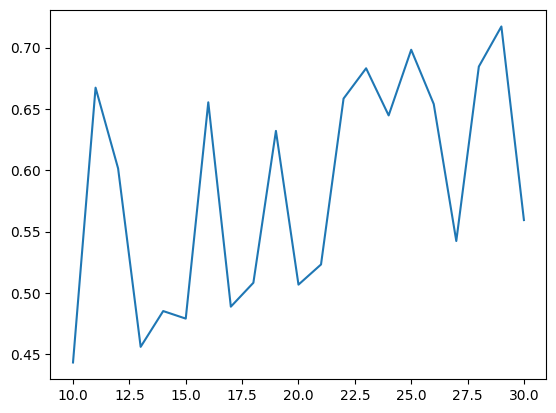

In [9]:
plt.plot(windowsizes, accuracy)

## Window size 30 -> 50

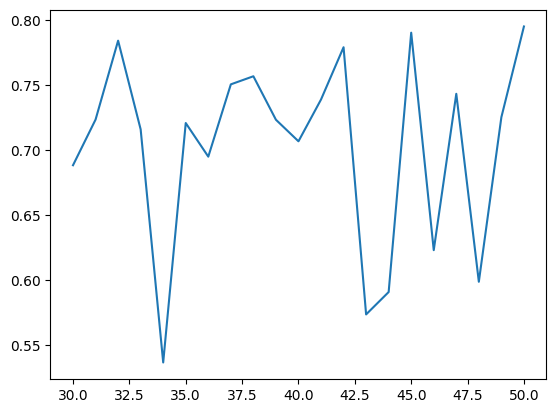

In [11]:
plt.plot(windowsizes, accuracy)

## Window size 50 -> 70

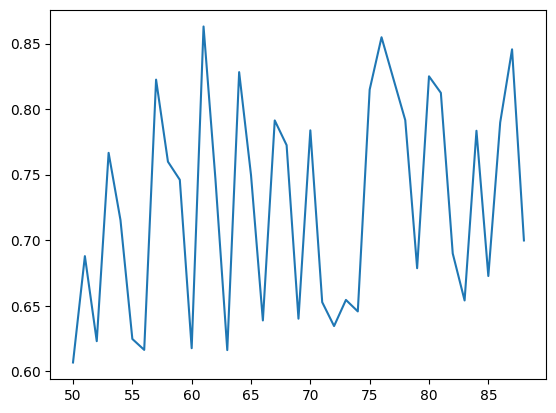

In [5]:
plt.plot(windowsizes, accuracy)

**Conclusion:** I had to cut the calculations in 3 parts, but in the end got my best accuracies using window sizes ranging from 10 to 90.
It does seem that the model flucutuates a lot on any given range, although one thing is clearly visible in the graphs: bigger window size on average means better model accuracy. Next parameter tuning should be about the neural network parameters.